In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

The goal of this project is to process real-life experimental data and provide solvent suggestion based on selected descriptors

In [60]:
class SolvPredPlus:
    
    def __init__(self, all_cand_param_csv, **kwargs):
        self.load_cand_param(all_cand_param_csv, **kwargs)
        pass
    
    def load_cand_param(self, all_cand_param_csv, **kwargs):
        """
        load database for all solvent parameters for candidates
        all_cand_param_csv: string, file name.
        The column row in the example includes: solvent, D, P, H, epsilon, pi_star, HBD, HBA, logP_solv
        user can specify additional properties to be calculated while loading candidate database. 
        for example, hansen distance with starting material and the product
        kwargs:
        do_hansen_dist: bool
        hansen_dist_with: list of dict or one dict, keys are comp_name, D, P, H
        """
        all_solv_cand_df = pd.read_csv(all_cand_param_csv)
        #convert to dictionary
        self.all_cand_param_dict = all_solv_cand_df.to_dict(orient='records')
        print(f"Loading candidate parameters: success.\n")
        
    def _calc_hansen_dist(self, crt_df, hansen_dist_with_dict):
        """
        calculate hansen distance with current dataframe HSP columns
        hansen_dist_with_dict: dictionary
        """
        hansen_dist_with_name = hansen_dist_with_dict["comp_name"]
        hansen_dist_col_name = '_'.join(['r', hansen_dist_with_name])
        this_D = hansen_dist_with_dict["D"]
        this_P = hansen_dist_with_dict["P"]
        this_H = hansen_dist_with_dict["H"]
        
        this_r = np.sqrt(4*(crt_df["D"]-this_D)**2 + (crt_df["P"] - this_P)**2 + (crt_df["H"] - this_H)**2)
        
        crt_df[hansen_dist_col_name] = this_r
        
        print(f"Calculate hansen distance with {hansen_dist_with_name}: success.")
        return crt_df

    
    def load_exp_data(self, ip_exp_csv, **kwargs):
        """
        ip_exp_csv is the file name of input experimental data.
        The columns of the data file should follow the naming rule as rxn_id, solv_1, precent_1, solv_2, percent_2, Y
        There could be more co-solvents column; the name should follow solv_#, precent_# structure.
        Y is the observable column, in the example is the yield.
        Important rule: the name for solvent must match the name used in the all_cand_param data file.
        Mixtures parameters will be calculated and attached in each entry.
        """
        full_exp_df = pd.read_csv(ip_exp_csv)
        self.all_co_solv_col_name = self._get_co_solv_col_name(full_exp_df)
        full_exp_dict = full_exp_df.to_dict(orient="records")
        
        #operate each row/entry one by one
        #fetch parameters of corresponding solvent from database
        #then scale by percentage
        all_comb_exp = []
        
        for exp in full_exp_dict:
            
            rxn_id = exp["rxn_id"]
            print(f"Process {rxn_id} starts..")
            
            for i, solv_col in enumerate(self.all_co_solv_col_name["solv_col"]):
                this_solv_name = exp[solv_col]
                
                if type(this_solv_name) is str:
                
                    percent_col = self.all_co_solv_col_name["percent_col"][i]
                    this_solv_percent = exp[percent_col]

                    #fetch all parameters for this solvent
                    this_solv_params = self._fetch_solv_param(this_solv_name)["full_params"]
                    #apply this_solv_percent to all parameters
                    this_solv_scaled_params = self._scale_param_by_percent(this_solv_params, this_solv_percent)

                    if i == 0:
                        mix_solv_params = this_solv_scaled_params
                    else:
                        mix_solv_params = self._add_dict(this_solv_scaled_params, mix_solv_params)
            
            #process kwargs if any
            #calculate hansen distance
            if "do_hansen_dist" in kwargs:

                if kwargs["do_hansen_dist"]:

                    if type(kwargs["hansen_dist_with"]) is dict:
                        #calculate the hansen distance to the all_solv_cand_df
                        #this is the case when only one species need to be calculated
                        all_solv_cand_df = self._calc_hansen_dist(all_solv_cand_df, kwargs["hansen_dist_with"])
                        pass
                    elif type(kwargs["hansen_dist_with"]) is list:
                        #loop over the list and append calculated hansen distance to the all_solv_cand_df
                        #this is the case when multiple species need to be calculated
                        for with_this_comp in kwargs["hansen_dist_with"]:
                            all_solv_cand_df = self._calc_hansen_dist(mix_solv_params, with_this_comp)
            
            #include mix_solv_params to the experimental dataset
            comb_exp_dict = exp
            comb_exp_dict.update(mix_solv_params)
            
            all_comb_exp.append(comb_exp_dict)
        
        self.all_comb_exp = all_comb_exp
        print("\nLoading data: success.\n")
        
        #the meta data can be saved or not, user's choice
        if "save_meta_data" in kwargs:
            if kwargs["save_meta_data"]:
                
                #generate meta data file name according to current time
#                 meta_data_file_name = kwargs["meta_op_name"]
                meta_data_file_name = "op_exp_data_with_full_params.csv"
                    
                pd.DataFrame(self.all_comb_exp).to_csv(meta_data_file_name, index = False)
                print(f"{meta_data_file_name} saved.")
            
                
#         return self.all_comb_exp
        
    def rm_zero(self):
        """
        remove zero yield data from column Y
        """
        non_zero_comb = []
        
        for entry in self.all_comb_exp:
            if entry['Y'] == 0:
                pass
            elif type(entry['Y']) not in [float, int]:
                err_rxn_id = entry["rxn_id"]
                raise ValueError(f"Wrong format found in the observable column. Please check entry: {err_rxn_id}. \n")
            else:
                non_zero_comb.append(entry)
        
        self.non_zero_comb = non_zero_comb
        print("Remove invalid/zero data: success.\n")
        self.non_zero_comb_df = pd.DataFrame(self.non_zero_comb)
        
        return self.non_zero_comb
                
        
    #parse column name and extract solv, precent part from the full columns
        
    def _get_co_solv_col_name(self, full_exp_df):
        """
        look at how many co-solvents are used in experiment.
        return column names for the solv/percent block
        """
        all_col = full_exp_df.columns
        #confirm how many co-solvents to parse
        all_co_solv = {
            "solv_col":[],
            "percent_col":[]
        }

        for i, col in enumerate(all_col):
            if "solv" in col.lower():
                this_solv_col = col
                this_percent_col = all_col[i+1]
                all_co_solv["solv_col"].append(this_solv_col)
                all_co_solv["percent_col"].append(this_percent_col)

        if len(all_co_solv["solv_col"]) == 0 or len(all_co_solv["percent_col"]) == 0:
            raise ValueError("Co-solvent or percent column was missing. Please check the input experimental data file.\n")
        elif len(all_co_solv["solv_col"]) != len(all_co_solv["percent_col"]):
            raise ValueError("Potential offset was detected in co-solvent and percentage info. Please check the input experimental data file.\n")
        
        #get total number of solvents in the mixture
        self.total_num_of_solv = len(all_co_solv["solv_col"])
        
        return all_co_solv

            
    
    def _scale_param_by_percent(self, full_param_dict, this_solv_percent):
        """
        scale each parameter by the percentage of current solvent
        """
        scaled_num_params = {}
        for item in full_param_dict.keys():
            this_value = full_param_dict[item]
            if type(this_value) is not str:
                scaled_num_params[item] = this_solv_percent * this_value
        return scaled_num_params
    
    def _add_dict(self, dict_1, dict_2):
        """
        dict_1 and dict_2 have same structure
        """
        mix_dict = {}
        for item in dict_1.keys():
            mix_dict[item] = dict_1[item] + dict_2[item]
        return mix_dict
        
    
    def _fetch_solv_param(self, solv_name):
        """
        fetch solvent parameters by solv_name
        """
        
        this_solv_params = {}
#         print(solv_name)
        
        for entry in self.all_cand_param_dict:
            #print(entry)
            
            if solv_name.lower() == entry["solvent"].lower():
                this_solv_params["this_solvent"] = solv_name
                this_solv_params["full_params"] = entry
        
#         print(this_solv_params)
        if not this_solv_params["this_solvent"]:
            raise ValueError("Target solvent absent from candidate database. Please check the solvent name or the database entry.")
        
        return this_solv_params
    
    
    #do corr plot, default Y with descriptors, can be modified by do any two columns
    def plot_corr(self, observable = "Y", plot_all = True, x_to_plot = ["D", "P", "H"], **kwargs):
        """
        plot correlation between observable and a series of x
        if plot_all is true, default will plot every descriptor in the dataset,
        otherwise, only descriptors in x_to_plot will be plot.
        plot details can be specified in kwargs
        """
        full_data = self.non_zero_comb_df
        
        if plot_all:
            #get all descriptors from full data list, find it after Y
            dscpt_col = self._get_full_descriptors_col()
            x_to_plot = dscpt_col
       
        for x_name in x_to_plot:
            sns.relplot(data = full_data, x = full_data[x_name], y = full_data[observable])
            plt.xlabel(x_name, fontsize = 15)
            plt.ylabel(observable, fontsize = 15)
            plt.tick_params(axis='both', which='major', labelsize=15)
            plt.tight_layout()
        
        pass
    
    def _get_full_descriptors_col(self):
        """
        get column name of all descriptors, assumed to be after Y
        """
        all_col_name = self.non_zero_comb_df.columns
        dscpt_start_idx = 0
        for i, col_name in enumerate(all_col_name):
            if col_name == "Y":
                dscpt_start_idx = i+1
        
        dscpt_col = all_col_name[dscpt_start_idx:]
        #print(dscpt_col)
        if len(dscpt_col) != 0:
            print(f"Generate full descriptor: success.")
        
        return dscpt_col
                
                
        
    
    
    

In [61]:
ip_exp_csv_name = "input_exp_data.csv"
all_cand_param_name = "all_candidates_param_at_rt.csv"

In [62]:
sm_hsp = {
    "comp_name":"sm",
    "D":18.2,
    "P":9.18,
    "H":13.4
}

prod_hsp = {
    "comp_name":"prod",
    "D":17.5,
    "P":5.7,
    "H":2.0
}

In [63]:
hansen_dist_with = [sm_hsp, prod_hsp]

In [64]:
spp = SolvPredPlus(all_cand_param_name)
#for this specific test, we can calculate hansen distance with s.m. and product
#the distance will be modified in all_cand_param_dict
spp.load_exp_data(ip_exp_csv_name, do_hansen_dist = True, hansen_dist_with = hansen_dist_with, save_meta_data = True)
#remove invalid observed data (zeros)
spp.rm_zero()
print(len(spp.all_comb_exp))
print(len(spp.non_zero_comb))
spp.non_zero_comb
spp.non_zero_comb_df

Loading candidate parameters: success.

Process Xf2346 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2353 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2345 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2344 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2352 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2350 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2351 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2356 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process xf2379 starts..
Calculate hansen distanc

,rxn_id,solv_1,percent_1,solv_2,percent_2,Y,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv,r_sm,r_prod
0,Xf2346,DMAC,1.0,NaN,NaN,0.82,16.80,11.50,10.20,37.780,0.880,0.000,0.760,-0.770,4.843800,10.141006
1,Xf2353,Acetone,1.0,NaN,NaN,0.72,15.50,10.40,7.00,20.700,0.600,0.100,0.500,-0.210,8.462175,7.942921
2,Xf2345,DMSO,1.0,NaN,NaN,0.70,18.40,16.40,10.20,46.450,1.000,0.000,0.760,-1.380,7.907490,13.600368
3,Xf2344,DMF,1.0,NaN,NaN,0.62,17.40,13.70,11.30,36.700,0.880,0.000,0.690,-1.310,5.234539,12.269067
4,Xf2352,ACN,1.0,NaN,NaN,0.52,15.30,18.00,6.10,37.500,0.750,0.190,0.400,-0.390,12.834422,13.691603
5,Xf2350,NPA,1.0,NaN,NaN,0.26,16.00,6.80,17.40,20.450,0.520,0.840,0.900,0.360,6.405029,15.728001
6,Xf2351,tBuOH,1.0,NaN,NaN,0.14,15.20,5.10,14.70,12.000,0.410,0.420,0.930,0.580,7.371323,13.520725
7,Xf2356,EA,1.0,NaN,NaN,0.01,15.80,5.30,7.20,6.020,0.550,0.000,0.450,0.710,8.748394,6.225753
8,xf2379,EA,0.2,acetone,0.8,0.35,15.56,9.38,7.04,17.764,0.590,0.080,0.490,-0.026,8.268494,7.348360
9,xf2380,EA,0.4,acetone,0.6,0.59,15.62,8.36,7.08,14.828,0.580,0.060,0.480,0.158,8.200024,6.857084


Generate full descriptor: success.


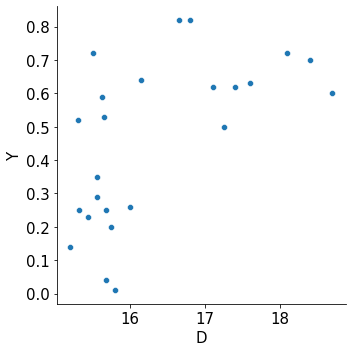

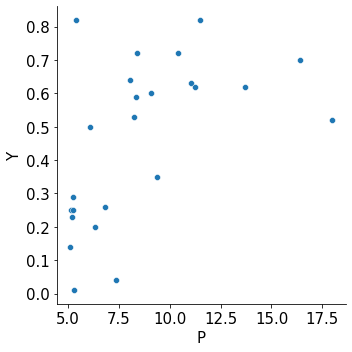

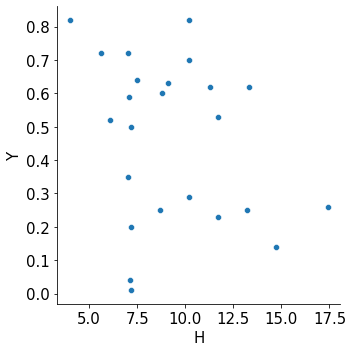

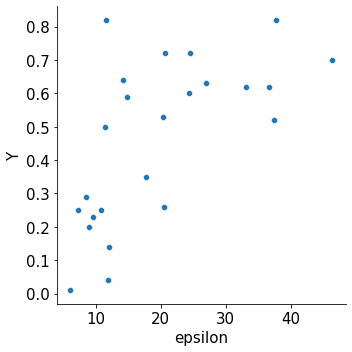

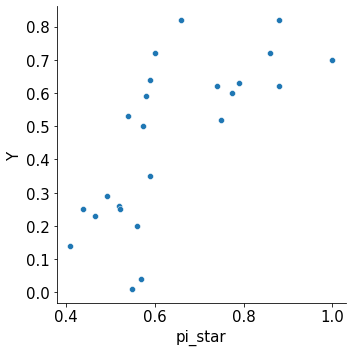

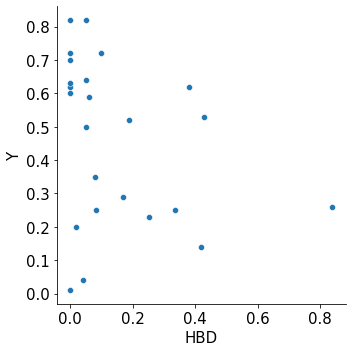

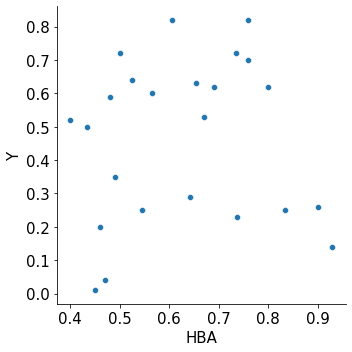

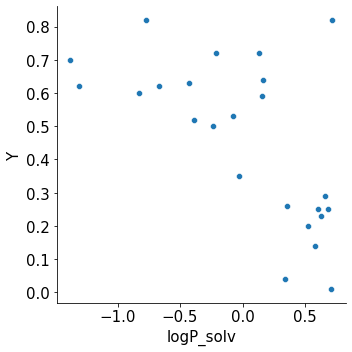

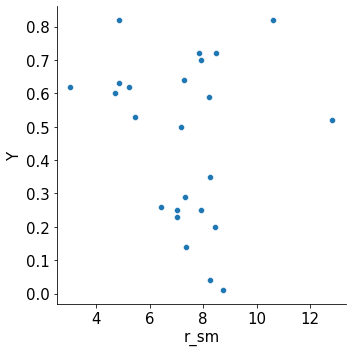

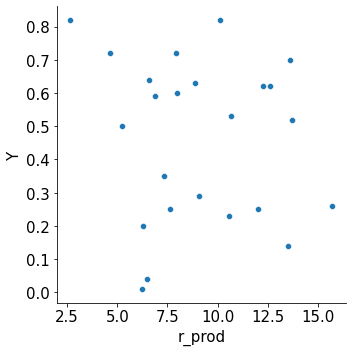

In [66]:
spp.plot_corr(plot_all = True)

In [12]:
all_solv_cand_df = pd.read_csv(all_cand_param_name)
# all_solv_cand_df.to_dict(orient = "records")

In [13]:
all_solv_cand_df.head()

,solvent,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv
0,DMAC,16.8,11.5,10.2,37.78,0.88,0.00,0.76,-0.77
1,Acetone,15.5,10.4,7.0,20.70,0.60,0.10,0.50,-0.21
2,DMSO,18.4,16.4,10.2,46.45,1.00,0.00,0.76,-1.38
3,DMF,17.4,13.7,11.3,36.70,0.88,0.00,0.69,-1.31
4,ACN,15.3,18.0,6.1,37.50,0.75,0.19,0.40,-0.39


In [14]:
all_solv_cand_df['new_col_test'] = (all_solv_cand_df['D']-1)**2+(all_solv_cand_df['P']+1)**2

In [15]:
all_solv_cand_df.head()

,solvent,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv,new_col_test
0,DMAC,16.8,11.5,10.2,37.78,0.88,0.00,0.76,-0.77,405.89
1,Acetone,15.5,10.4,7.0,20.70,0.60,0.10,0.50,-0.21,340.21
2,DMSO,18.4,16.4,10.2,46.45,1.00,0.00,0.76,-1.38,605.52
3,DMF,17.4,13.7,11.3,36.70,0.88,0.00,0.69,-1.31,485.05
4,ACN,15.3,18.0,6.1,37.50,0.75,0.19,0.40,-0.39,565.49


In [3]:
full_exp_df = pd.read_csv(ip_exp_csv_name)
full_exp_df.head()

,rxn_id,solv_1,percent_1,solv_2,percent_2,Y
0,Xf2346,DMAC,1.0,NaN,NaN,0.82
1,Xf2353,Acetone,1.0,NaN,NaN,0.72
2,Xf2345,DMSO,1.0,NaN,NaN,0.70
3,Xf2344,DMF,1.0,NaN,NaN,0.62
4,Xf2352,ACN,1.0,NaN,NaN,0.52


In [34]:
full_exp_df.to_dict(orient = "records")

[{'rxn_id': 'Xf2346',
  'solv_1': 'DMAC',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.82},
 {'rxn_id': 'Xf2353',
  'solv_1': 'Acetone',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.72},
 {'rxn_id': 'Xf2345',
  'solv_1': 'DMSO',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.7},
 {'rxn_id': 'Xf2344',
  'solv_1': 'DMF',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.62},
 {'rxn_id': 'Xf2352',
  'solv_1': 'ACN',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.52},
 {'rxn_id': 'Xf2350',
  'solv_1': 'NPA',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.26},
 {'rxn_id': 'Xf2351',
  'solv_1': 'tBuOH',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.14},
 {'rxn_id': 'Xf2356',
  'solv_1': 'EA',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.01},
 {'rxn_id': 'xf2379',
  'solv_1': 'EA',
  'percent_1': 0.2,
  'solv_2': 'acetone',
  'percent_2': 

In [12]:
all_col = full_exp_df.columns

In [15]:
for i, col in enumerate(all_col):
    if "solv" in col.lower():
        this_solv = col
        this_precent = all_col[i+1]
        print(this_solv)
        print(this_precent)

solv_1
percent_1
solv_2
percent_2


In [24]:
#parse column name and extract solv, precent part
def parse_co_solv(full_exp_df):
    all_col = full_exp_df.columns
    
    all_co_solv = {
        "solv_col":[],
        "percent_col":[]
    }
    
    for i, col in enumerate(all_col):
        if "solv" in col.lower():
            this_solv_col = col
            this_percent_col = all_col[i+1]
            all_co_solv["solv_col"].append(this_solv_col)
            all_co_solv["percent_col"].append(this_percent_col)
    
    return all_co_solv
            

In [25]:
all_co_solv = parse_co_solv(full_exp_df)
print(all_co_solv)

{'solv_col': ['solv_1', 'solv_2'], 'percent_col': ['percent_1', 'percent_2']}
